### 생성 모델이란
$$p(\mathbf{x})$$
- x가 발생할 확률분포 $p(\mathbf{x})$를 알면 새로운 샘플을 생성할 수 있음
- 생성 모델은 레이블 없이 $x$만 가지고 확률 분포를 추정하므로 비지도 학습임

#### 다룸 가능(tractable)
- 특징이 2개 뿐이고 특징이 가질 수 있는 값이 0과 1일때는 다룸 가능
  - 확률 분포 $p(\mathbf{x})$를 배열로 표현하고, 데이터셋으로 $p(\mathbf{x})$를 추정(학습)하고, $p(\mathbf{x})$에서 샘플링하는 일이 모두 쉬움
- $P_{data}$에서 무수히 많이 샘플링하여 데이터셋 $X$를 무한히 크게 하면 $X$로 추정한 $P_{model}$은 $P_{data}$와 같게 됨


#### 다룸 불가능(intractable)
- 실제 세상은 $\mathbf{x}$가 수백~수만 차원, 특징은 수백 개 값이 가능한 정수 또는 실수
  - ex) MNIST: 256개 값이 가능한 특징이 784개 $\rightarrow 256^{784}$ 크기의 배열 필요

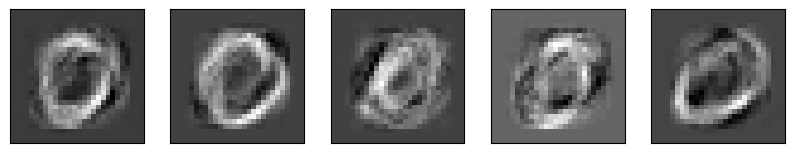

In [4]:
import numpy as np
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data() # 데이터셋 구성
X = x_train[np.isin(y_train, [0])] # 0부류만 추출
X = X.reshape((X.shape[0], 28*28))

m = np.mean(X, axis=0)
cp = np.cov(X, rowvar=False) # 모델학습

gen = np.random.multivariate_normal(m, cp, 5) # 샘플 생성

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4)) # 샘플 그리기
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(gen[i].reshape((28, 28)), cmap='gray')
  plt.xticks([])
  plt.yticks([])

### 가우시안 혼합 모델(GMM; Gaussian Mixture Model)
- 가우시안을 k개 혼합하여 실제 분포에 더 가깝게 모델링
$$p(\mathbf{x}) = \sum_{i=1, k}\pi N(\mathbf{\mu}_i\sum_i)$$

#### 가우시안 혼합 모델의 한계
- 가우시안 혼합 모델은 데이터가 가우시안 분포를 한다는 가정을 통해 다룸 가능 확보
- 실제로는 데이터가 가우시안 분포와 멀기 때문에 생성 모델로서 한계를 보임

### 생성 모델의 학습 알고리즘이 할 일을 최대 우도 추정으로 간주
- 우리가 가진 것은 데이터셋 $X = {\mathbf{x}^1,\mathbf{x}^2,\cdots,\mathbf{x}^n}$ 뿐
- 데이터셋을 가장 잘 설명하는 매개변수 값을 찾는 일을 최대우도로 표현
$$\hat{\theta} = argmax p_{\theta}(X)$$

### AutoEncoder -> Convolution Neural Network
- 비지도 학습
- 특징 추출기 또는 영상 압축기 등으로 활용
- 여기서는 생성 모델로 활용

#### 생성 모델로서 AutoEncoder
- 학습을 마치면 인코더를 버리고 디코더만 취함
- 잠복 공간에서 랜덤 벡터 생성한 후 디코더를 통해 영상 생성

In [5]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

zdim = 32

In [7]:
encoder_input = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1,1))(encoder_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1,1))(x)
x = Flatten()(x)
encoder_output = Dense(zdim)(x)
model_encoder = Model(encoder_input, encoder_output)

In [8]:
decoder_input = Input(shape=(zdim,))
x = Dense(3136)(decoder_input)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(1,1))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2DTranspose(1, (3, 3), activation='relu', padding='same', strides=(1,1))(x)
decoder_output = x
model_decoder = Model(decoder_input, decoder_output)

In [10]:
model_input = encoder_input
model_output = model_decoder(encoder_output)
model = Model(model_input, model_output)

In [11]:
model.compile(optimizer='adam', loss='mse') # 오토인코더 학습
model.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.0378 - val_loss: 0.0062
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/st

In [12]:
i = np.random.randint(x_test.shape[0])
j = np.random.randint(x_test.shape[0])
x = np.array((x_test[i], x_test[j]))
z = model_encoder.predict(x)
zz = np.zeros((11, zdim))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


In [13]:
alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i in range(11):
  zz[i] = (1.0-alpha[i])*z[0]+alpha[i]*z[1]

gen = model_decoder.predict(zz)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


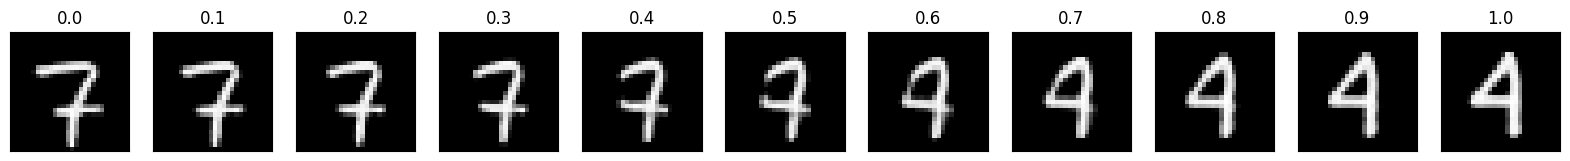

In [14]:
plt.figure(figsize=(20, 4))
for i in range(11):
  plt.subplot(1, 11, i+1)
  plt.imshow(gen[i].reshape((28, 28)), cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(str(alpha[i]))

### 변이 추론
#### 생성 모델로서 오토인코더의 한계
- 필기 숫자를 모델링할 수 있을 정도로 개선되었지만 사람 얼굴이나 자연 영상등에 적용 불가능

#### 변이추론(variational inference)의 중요성
- 오토인코더를 생성 모델로 확장하는 변이 오토인코더는 변이 추론에 기반
- DALL-E 같은 언어-비전 생성 모델이 변이 추론 활용